In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy import sparse
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
df = pd.read_csv("train_20200418.csv")

In [3]:
df.head()

,label,original,text,favorite_count,retweet_count,user.followers_count,user.friends_count,user.verified,user.created_at,created_at,txt_len,avg_wrd_length,url_cnt,puncutaion_cnt,tweet_age
0,1,Michael Brown was suspected of robbing store i...,michael brown suspect rob store shot say police,88,161,115083,1873,True,Thu Aug 27 16:09:18 +0000 2009,Fri Aug 15 16:00:49 +0000 2014,13,5.0,2,1,4.97
1,1,Police chief said officer who shot Brown didn'...,police chief say officer shot brown know robbery,47,202,3066,606,True,Thu Apr 09 02:33:23 +0000 2009,Fri Aug 15 19:12:26 +0000 2014,13,4.0,0,0,5.35
2,1,Report: #Ferguson police beat up wrong suspect...,report police beat wrong suspect charge get bl...,73,168,162748,521,True,Fri May 09 19:46:43 +0000 2008,Fri Aug 15 17:00:52 +0000 2014,16,5.0,1,0,6.27
3,1,So basically #Ferguson PD hijacked what was su...,basically pd hijack suppose press conference d...,159,446,3593,2590,False,Tue Jan 08 23:31:12 +0000 2008,Fri Aug 15 14:45:30 +0000 2014,21,5.0,0,0,6.60
4,1,Report: #Ferguson police beat up wrong suspect...,report police beat wrong suspect charge get bl...,43,126,162744,521,True,Fri May 09 19:46:43 +0000 2008,Fri Aug 15 20:39:00 +0000 2014,16,5.0,1,0,6.27


In [7]:
df.shape

(5802, 15)

In [9]:
## remove row with blank text
df = df.dropna(subset=['text'])

In [10]:
df.shape

(5798, 15)

In [21]:
#split train test
X_train, X_test, y_train, y_test = train_test_split(df[['text','favorite_count','retweet_count','user.followers_count','user.friends_count','user.verified','txt_len','avg_wrd_length','url_cnt','puncutaion_cnt','tweet_age']], 
                                                    df['label'], 
                                                    test_size=0.2, 
                                                    random_state=8)

In [64]:
X_train.head(100)

,text,favorite_count,retweet_count,user.followers_count,user.friends_count,user.verified,txt_len,avg_wrd_length,url_cnt,puncutaion_cnt,tweet_age
1374,break news shot fire hostage take town northea...,21,145,1928042,644,True,11,5.0,1,1,5.72
4908,another hostage see run cafe,86,154,41309,397,True,10,4.0,0,0,4.50
5458,send love sydney horrible situation stay safe ...,6547,3450,1031854,291,True,11,5.0,0,5,5.94
4849,report appear two people confirm dead three se...,70,257,20994,886,True,14,5.0,0,3,4.73
2548,agence france presse staff line proclaim,225,281,824784,2355,True,8,5.0,2,1,6.49
...,...,...,...,...,...,...,...,...,...,...,...
5555,math stop conflation collateral indictment mus...,162,204,9896,570,False,12,6.0,1,2,1.13
1844,terrorist action perpetrate paris islam read c...,59,134,4281,39,False,18,5.0,1,1,4.08
3153,white terrorist mentally ill brown terrorist i...,48,100,94562,27660,False,11,6.0,1,2,2.92
2131,sick ppl tiptoe around fact islamic attack pol...,312,230,43728,177,False,23,4.0,0,2,3.21


In [22]:
## Build word vectors for injecting in model
cv = CountVectorizer()
X_train_counts = cv.fit_transform(X_train['text'])

tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_counts)

In [40]:
X_train_addF = X_train[['favorite_count','retweet_count','user.followers_count','user.friends_count','user.verified','txt_len','avg_wrd_length','url_cnt','puncutaion_cnt','tweet_age']]

In [41]:
X_train_addF.head()

,favorite_count,retweet_count,user.followers_count,user.friends_count,user.verified,txt_len,avg_wrd_length,url_cnt,puncutaion_cnt,tweet_age
1374,21,145,1928042,644,True,11,5.0,1,1,5.72
4908,86,154,41309,397,True,10,4.0,0,0,4.50
5458,6547,3450,1031854,291,True,11,5.0,0,5,5.94
4849,70,257,20994,886,True,14,5.0,0,3,4.73
2548,225,281,824784,2355,True,8,5.0,2,1,6.49


In [48]:
Xtrain_matrix = np.asmatrix(X_train_addF.values)

In [55]:
X_f_train=sparse.hstack([X_train_tfidf,Xtrain_matrix.astype(float)])

In [59]:
#Normalizing values
normalized_X_train = preprocessing.normalize(X_f_train)

## Naive Bayes

In [65]:
## Build NB
clf = MultinomialNB()
clf.fit(normalized_X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [67]:
## training accuracy with additional figures
clf.score(normalized_X_train, y_train)

0.6569642087106511

In [68]:
## training accuracy with text features only

clf_plain = MultinomialNB()
clf_plain.fit(X_train_tfidf, y_train)
clf_plain.score(X_train_tfidf, y_train)

0.9010349288486417

In [69]:
##formatting test data
test_x_counts = cv.transform(X_test['text'])
test_x_tfidf = tfidf.transform(test_x_counts)
predict_y = clf_plain.predict(test_x_tfidf)

In [71]:
X_test_addF = X_test[['favorite_count','retweet_count','user.followers_count','user.friends_count','user.verified','txt_len','avg_wrd_length','url_cnt','puncutaion_cnt','tweet_age']]
Xtest_matrix = np.asmatrix(X_test_addF.values)
X_f_test=sparse.hstack([test_x_tfidf,Xtest_matrix.astype(float)])
normalized_X_test = preprocessing.normalize(X_f_test)

In [72]:
predict_y_add = clf.predict(normalized_X_test)

In [73]:
## test accuracy with additional figures
accuracy_score(y_test, predict_y_add)

0.6715517241379311

In [70]:
## test accuracy with text features only
accuracy_score(y_test, predict_y)

0.8362068965517241

## other models
### GXBoost

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [80]:
model = XGBClassifier()
model.fit(normalized_X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [81]:
# make predictions for test data
y_pred_xgboost = model.predict(normalized_X_test)
y_pred_xgboost

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [82]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred_xgboost)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.67%


### Tune Hyperparameter

In [105]:
params = model.get_xgb_params()

In [106]:
xgtrain = xgb.DMatrix(normalized_X_train, label=y_train)

In [111]:
## get no.of trees for learning rate 0.3
cv_results = xgb.cv(
    params,
    xgtrain,
    num_boost_round=10000,
    seed=42,
    nfold=5,
    metrics={'error'},
    early_stopping_rounds=200,
    verbose_eval=50
)

[0]	train-error:0.20585+0.00389	test-error:0.24406+0.01763
[50]	train-error:0.06641+0.00314	test-error:0.16494+0.01524
[100]	train-error:0.03757+0.00133	test-error:0.15955+0.01374
[150]	train-error:0.02183+0.00105	test-error:0.15696+0.01107
[200]	train-error:0.01331+0.00129	test-error:0.15718+0.01191
[250]	train-error:0.00609+0.00070	test-error:0.15998+0.01321
[300]	train-error:0.00329+0.00075	test-error:0.16106+0.01052
[350]	train-error:0.00140+0.00031	test-error:0.16170+0.01143
[400]	train-error:0.00049+0.00026	test-error:0.16365+0.01229


In [109]:
cv_results.head()

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.205854,0.003886,0.244065,0.017631
1,0.180789,0.002602,0.228544,0.010872
2,0.180842,0.007079,0.226170,0.018609
3,0.171410,0.003753,0.225093,0.013836
4,0.162301,0.001313,0.217331,0.017343


In [115]:
boost_rounds = cv_results['test-error-mean'].idxmin()
boost_rounds

210

In [123]:
# Create the parameter grid 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit

max_depth = range(3,10,2)
min_child_weight = range(1,6,2)
subsample = [i/10.0 for i in range(6,10)]
colsample_bytree = [i/100.0 for i in range(75,90,5)]

param_grid = {
    'max_depth': max_depth,
    'min_child_weight': min_child_weight,
    'subsample': subsample,
    'colsample_bytree': colsample_bytree
}



# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=XGBClassifier(learning_rate =0.3, n_estimators=boost_rounds+5, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=50)

# Fit the grid search to the data
grid_search.fit(normalized_X_train, y_train)


Fitting 3 folds for each of 144 candidates, totalling 432 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] colsample_bytree=0.75, max_depth=3, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=0.75, max_depth=3, min_child_weight=1, subsample=0.6, score=0.813, total=   2.7s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[CV] colsample_bytree=0.75, max_depth=3, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=0.75, max_depth=3, min_child_weight=1, subsample=0.6, score=0.828, total=   2.7s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.2s remaining:    0.0s
[CV] colsample_bytree=0.75, max_depth=3, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=0.75, max_depth=3, min_child_weight=1, subsample=0.6, score=0.830, total=   2.2s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.4s remaining:    0.0s
[CV] colsample_bytree=0.75, max_depth=3, min_child_weight=1, subsample=0.7 


[CV]  colsample_bytree=0.75, max_depth=3, min_child_weight=5, subsample=0.8, score=0.809, total=   2.9s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  1.5min remaining:    0.0s
[CV] colsample_bytree=0.75, max_depth=3, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.75, max_depth=3, min_child_weight=5, subsample=0.8, score=0.809, total=   2.7s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  1.6min remaining:    0.0s
[CV] colsample_bytree=0.75, max_depth=3, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.75, max_depth=3, min_child_weight=5, subsample=0.9, score=0.806, total=   3.5s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  1.6min remaining:    0.0s
[CV] colsample_bytree=0.75, max_depth=3, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.75, max_depth=3, min_child_weight=5, subsample=0.9, score=0.815, total=   2.8s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.7min remaining:    0.0s
[CV] colsample_bytree=0.75, max_dept

[CV]  colsample_bytree=0.75, max_depth=5, min_child_weight=5, subsample=0.9, score=0.803, total=   3.8s
[CV] colsample_bytree=0.75, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.75, max_depth=5, min_child_weight=5, subsample=0.9, score=0.792, total=   4.9s
[CV] colsample_bytree=0.75, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.75, max_depth=5, min_child_weight=5, subsample=0.9, score=0.799, total=   5.1s
[CV] colsample_bytree=0.75, max_depth=7, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=0.75, max_depth=7, min_child_weight=1, subsample=0.6, score=0.815, total=   5.1s
[CV] colsample_bytree=0.75, max_depth=7, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=0.75, max_depth=7, min_child_weight=1, subsample=0.6, score=0.833, total=   6.4s
[CV] colsample_bytree=0.75, max_depth=7, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=0.75, max_depth=7, min_child_weight=1, subsample=0.6, score=0.820, total=   6

[CV]  colsample_bytree=0.75, max_depth=9, min_child_weight=1, subsample=0.8, score=0.822, total=   7.3s
[CV] colsample_bytree=0.75, max_depth=9, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.75, max_depth=9, min_child_weight=1, subsample=0.8, score=0.824, total=   7.4s
[CV] colsample_bytree=0.75, max_depth=9, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.75, max_depth=9, min_child_weight=1, subsample=0.9, score=0.828, total=   7.5s
[CV] colsample_bytree=0.75, max_depth=9, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.75, max_depth=9, min_child_weight=1, subsample=0.9, score=0.835, total=   7.4s
[CV] colsample_bytree=0.75, max_depth=9, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.75, max_depth=9, min_child_weight=1, subsample=0.9, score=0.833, total=   7.5s
[CV] colsample_bytree=0.75, max_depth=9, min_child_weight=3, subsample=0.6 
[CV]  colsample_bytree=0.75, max_depth=9, min_child_weight=3, subsample=0.6, score=0.791, total=   6

[CV]  colsample_bytree=0.8, max_depth=3, min_child_weight=3, subsample=0.7, score=0.817, total=   2.7s
[CV] colsample_bytree=0.8, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, max_depth=3, min_child_weight=3, subsample=0.8, score=0.811, total=   2.4s
[CV] colsample_bytree=0.8, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, max_depth=3, min_child_weight=3, subsample=0.8, score=0.829, total=   2.5s
[CV] colsample_bytree=0.8, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.8, max_depth=3, min_child_weight=3, subsample=0.8, score=0.821, total=   2.9s
[CV] colsample_bytree=0.8, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, max_depth=3, min_child_weight=3, subsample=0.9, score=0.818, total=   3.3s
[CV] colsample_bytree=0.8, max_depth=3, min_child_weight=3, subsample=0.9 
[CV]  colsample_bytree=0.8, max_depth=3, min_child_weight=3, subsample=0.9, score=0.828, total=   3.6s
[CV] co

[CV]  colsample_bytree=0.8, max_depth=5, min_child_weight=5, subsample=0.7, score=0.789, total=   4.8s
[CV] colsample_bytree=0.8, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.8, max_depth=5, min_child_weight=5, subsample=0.7, score=0.792, total=   4.5s
[CV] colsample_bytree=0.8, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, max_depth=5, min_child_weight=5, subsample=0.8, score=0.807, total=   4.1s
[CV] colsample_bytree=0.8, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, max_depth=5, min_child_weight=5, subsample=0.8, score=0.796, total=   5.5s
[CV] colsample_bytree=0.8, max_depth=5, min_child_weight=5, subsample=0.8 
[CV]  colsample_bytree=0.8, max_depth=5, min_child_weight=5, subsample=0.8, score=0.795, total=   5.6s
[CV] colsample_bytree=0.8, max_depth=5, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.8, max_depth=5, min_child_weight=5, subsample=0.9, score=0.799, total=   4.5s
[CV] co

[CV]  colsample_bytree=0.8, max_depth=9, min_child_weight=1, subsample=0.7, score=0.812, total=   8.1s
[CV] colsample_bytree=0.8, max_depth=9, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, max_depth=9, min_child_weight=1, subsample=0.7, score=0.828, total=   7.2s
[CV] colsample_bytree=0.8, max_depth=9, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.8, max_depth=9, min_child_weight=1, subsample=0.7, score=0.809, total=   6.9s
[CV] colsample_bytree=0.8, max_depth=9, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.8, max_depth=9, min_child_weight=1, subsample=0.8, score=0.816, total=   7.3s
[CV] colsample_bytree=0.8, max_depth=9, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.8, max_depth=9, min_child_weight=1, subsample=0.8, score=0.833, total=   7.3s
[CV] colsample_bytree=0.8, max_depth=9, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.8, max_depth=9, min_child_weight=1, subsample=0.8, score=0.821, total=   5.8s
[CV] co

[CV]  colsample_bytree=0.85, max_depth=3, min_child_weight=3, subsample=0.6, score=0.819, total=   1.8s
[CV] colsample_bytree=0.85, max_depth=3, min_child_weight=3, subsample=0.6 
[CV]  colsample_bytree=0.85, max_depth=3, min_child_weight=3, subsample=0.6, score=0.815, total=   1.7s
[CV] colsample_bytree=0.85, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.85, max_depth=3, min_child_weight=3, subsample=0.7, score=0.813, total=   1.8s
[CV] colsample_bytree=0.85, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.85, max_depth=3, min_child_weight=3, subsample=0.7, score=0.815, total=   1.8s
[CV] colsample_bytree=0.85, max_depth=3, min_child_weight=3, subsample=0.7 
[CV]  colsample_bytree=0.85, max_depth=3, min_child_weight=3, subsample=0.7, score=0.811, total=   1.7s
[CV] colsample_bytree=0.85, max_depth=3, min_child_weight=3, subsample=0.8 
[CV]  colsample_bytree=0.85, max_depth=3, min_child_weight=3, subsample=0.8, score=0.813, total=   1

[CV]  colsample_bytree=0.85, max_depth=5, min_child_weight=3, subsample=0.9, score=0.804, total=   3.7s
[CV] colsample_bytree=0.85, max_depth=5, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.85, max_depth=5, min_child_weight=5, subsample=0.6, score=0.798, total=   3.2s
[CV] colsample_bytree=0.85, max_depth=5, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.85, max_depth=5, min_child_weight=5, subsample=0.6, score=0.786, total=   4.0s
[CV] colsample_bytree=0.85, max_depth=5, min_child_weight=5, subsample=0.6 
[CV]  colsample_bytree=0.85, max_depth=5, min_child_weight=5, subsample=0.6, score=0.787, total=   3.5s
[CV] colsample_bytree=0.85, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.85, max_depth=5, min_child_weight=5, subsample=0.7, score=0.796, total=   3.4s
[CV] colsample_bytree=0.85, max_depth=5, min_child_weight=5, subsample=0.7 
[CV]  colsample_bytree=0.85, max_depth=5, min_child_weight=5, subsample=0.7, score=0.787, total=   3

[CV]  colsample_bytree=0.85, max_depth=7, min_child_weight=5, subsample=0.9, score=0.791, total=   5.4s
[CV] colsample_bytree=0.85, max_depth=7, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.85, max_depth=7, min_child_weight=5, subsample=0.9, score=0.794, total=   4.7s
[CV] colsample_bytree=0.85, max_depth=7, min_child_weight=5, subsample=0.9 
[CV]  colsample_bytree=0.85, max_depth=7, min_child_weight=5, subsample=0.9, score=0.794, total=   4.8s
[CV] colsample_bytree=0.85, max_depth=9, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=0.85, max_depth=9, min_child_weight=1, subsample=0.6, score=0.813, total=   6.0s
[CV] colsample_bytree=0.85, max_depth=9, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=0.85, max_depth=9, min_child_weight=1, subsample=0.6, score=0.821, total=   5.7s
[CV] colsample_bytree=0.85, max_depth=9, min_child_weight=1, subsample=0.6 
[CV]  colsample_bytree=0.85, max_depth=9, min_child_weight=1, subsample=0.6, score=0.815, total=   5

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [124]:
## check best performing score
grid_search.best_score_

0.8404093185281951

In [125]:
# check best performing parameters
grid_search.best_params_

{'colsample_bytree': 0.8,
 'max_depth': 5,
 'min_child_weight': 1,
 'subsample': 0.9}

In [126]:
## build best performing model
best_xgb = grid_search.best_estimator_

In [149]:
check_2 = pd.DataFrame(normalized_X_train.toarray())
check_2.head()

,0,1,2,3,4,5,6,7,8,9,...,4821,4822,4823,4824,4825,4826,4827,4828,4829,4830
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000011,0.000075,1.000000,0.000334,5.186609e-07,0.000006,0.000003,5.186609e-07,5.186609e-07,0.000003
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002082,0.003728,0.999945,0.009610,2.420646e-05,0.000242,0.000097,0.000000e+00,0.000000e+00,0.000109
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.006345,0.003343,0.999974,0.000282,9.691044e-07,0.000011,0.000005,0.000000e+00,4.845522e-06,0.000006
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003331,0.012230,0.999030,0.042162,4.758646e-05,0.000666,0.000238,0.000000e+00,1.427594e-04,0.000225
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000273,0.000341,0.999996,0.002855,1.212434e-06,0.000010,0.000006,2.424867e-06,1.212434e-06,0.000008


In [150]:
## test accuracy score for best performing model
best_xgb.fit(normalized_X_train, y_train)
y_pred_xgboost_best = best_xgb.predict(normalized_X_test)
accuracy_best = accuracy_score(y_test, y_pred_xgboost_best)

In [151]:
## increased accuracy
accuracy_best

0.843103448275862

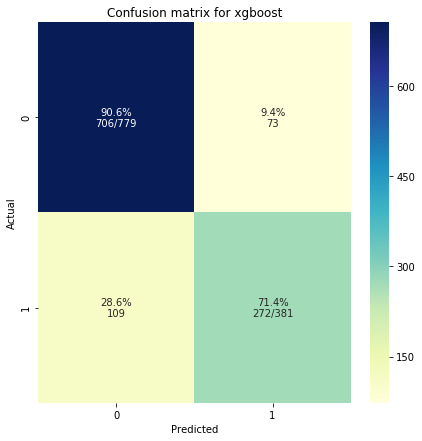

In [159]:
## build confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
plot_cm(y_test, y_pred_xgboost_best, 'Confusion matrix for xgboost', figsize=(7,7))

In [131]:
best_xgb_without = grid_search.best_estimator_

In [132]:
## train best performing model with text feature only
## obtain test accuracy score 
best_xgb_without.fit(X_train_tfidf, y_train)
y_pred_xgboost_best_without = best_xgb_without.predict(test_x_tfidf)
accuracy_best = accuracy_score(y_test, y_pred_xgboost_best_without)

In [133]:
## test accuracy score with text feature only
accuracy_best

0.8310344827586207

In [134]:
## export feature importance for analysis
imp = pd.DataFrame(model.feature_importances_)

In [135]:
imp.to_csv(r'C:\Users\s_shuang\Documents\Personal\MSBA Sem4\BT5153\Project\imp_best.csv')

In [91]:
## first iteration XGBoost without additional features
model_2 = XGBClassifier()
model_2.fit(X_train_tfidf, y_train)
y_pred_xgboost_without = model_2.predict(test_x_tfidf)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred_xgboost_without)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.05%


### LightGBM

In [92]:
## first iteration lightGBM without additional features
model_lgb = LGBMClassifier()
model_lgb.fit(normalized_X_train, y_train)

predicted_y_lgb = model_lgb.predict(normalized_X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, predicted_y_lgb)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.28%


In [93]:
## without additional features
model_lgb_without = LGBMClassifier()
model_lgb_without.fit(X_train_tfidf, y_train)
y_pred_lgb_without = model_lgb_without.predict(test_x_tfidf)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred_lgb_without)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.33%


### Logistic regression

In [102]:
from sklearn import metrics

from sklearn.linear_model import LogisticRegression


logreg = LogisticRegression(max_iter=100)

%time logreg.fit(normalized_X_train, y_train)

Wall time: 264 ms


C:\Users\s_shuang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [103]:
y_pred_class_lr = logreg.predict(normalized_X_test)
metrics.accuracy_score(y_test, y_pred_class_lr)

0.6715517241379311

In [104]:
##without addtional features
logreg_without = LogisticRegression(max_iter=100)

%time logreg_without.fit(X_train_tfidf, y_train)
y_pred_class_lr_without = model_lgb_without.predict(test_x_tfidf)
# evaluate predictions
lrwithout_accuracy = metrics.accuracy_score(y_test, y_pred_lgb_without)
lrwithout_accuracy

Wall time: 17.7 ms


0.8232758620689655

## Application

In [136]:
covid = pd.read_csv("test_20200419_v2.csv")

In [137]:
covid.head()

,label,text,original,favorite_count,retweet_count,user.followers_count,user.friends_count,user.verified,user.created_at,created_at,txt_len,avg_wrd_length,url_cnt,puncutaion_cnt,tweet_age
0,0.0,day 4 19 day lockdown 2 0 day 25 40 day lockdo...,Day 4 of the 19-day lockdown 2.0 and day 25 of...,6,8,5839,122,True,2013-08-12T01:25:28Z,2020-04-19T12:20:38Z,34,4.0,0,5,6.69
1,0.0,viral message claim restaurant hotel resort cl...,"A viral message claims that all restaurants, h...",11,6,56800,1183,True,2014-03-12T01:25:28Z,2020-04-18T16:30:38Z,26,5.0,0,4,6.11
2,0.0,map exists old nothing current outbreak corona...,"#WebQoof | While the map exists, it is old and...",5,4,6527,41,True,2018-09-12T01:25:28Z,2020-04-18T15:30:38Z,37,4.0,0,3,1.60
3,0.0,study show period onset clinical recovery last...,Studies show that the period from the onset to...,53,27,3200000,403,True,2011-07-12T01:25:28Z,2020-04-18T14:53:38Z,24,4.0,0,2,8.78
4,0.0,fact check hospital compensate covid 19 patien...,Fact Check: Some Hospitals Compensated For COV...,0,1,4447,3013,True,2015-06-12T01:25:28Z,2020-04-18T19:58:38Z,19,6.0,1,2,4.85


In [139]:
covid = covid.dropna(subset=['text'])

In [140]:
covid.shape

(2010, 15)

In [141]:
## transforming text to word vectors
covid_test_x_counts = cv.transform(covid['text'])
covid_test_x_tfidf = tfidf.transform(covid_test_x_counts)

In [142]:
## add additional features and normalize
covid_X_addF = covid[['favorite_count','retweet_count','user.followers_count','user.friends_count','user.verified','txt_len','avg_wrd_length','url_cnt','puncutaion_cnt','tweet_age']]
Covid_X_matrix = np.asmatrix(covid_X_addF.values)
covid_X_f_test=sparse.hstack([covid_test_x_tfidf,Covid_X_matrix.astype(float)])
covid_normalized_X_test = preprocessing.normalize(covid_X_f_test)

In [152]:
## predict the test result using best performance model
covidy_pred_xgboost_best = best_xgb.predict(covid_normalized_X_test)

In [153]:
## test result
covidy_pred_xgboost_best

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [154]:
## export test result
covid_result = pd.DataFrame(covidy_pred_xgboost_best)
covid_result.to_csv(r'C:\Users\s_shuang\Documents\Personal\MSBA Sem4\BT5153\Project\covid_result.csv')